Nombre de lignes pour le cluster 0 : 192683


C:\Users\asus\AppData\Local\Temp\ipykernel_16292\2106011425.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster_0['anomalie'] = data_cluster_0['anomalie'].astype(int)


Nombre d'échantillons générés : 192682
Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57299
           1       0.97      0.66      0.78       506

    accuracy                           1.00     57805
   macro avg       0.98      0.83      0.89     57805
weighted avg       1.00      1.00      1.00     57805

Exactitude : 0.9968168843525647
Précision pour la classe '1' (anomalie) : 0.9653179190751445


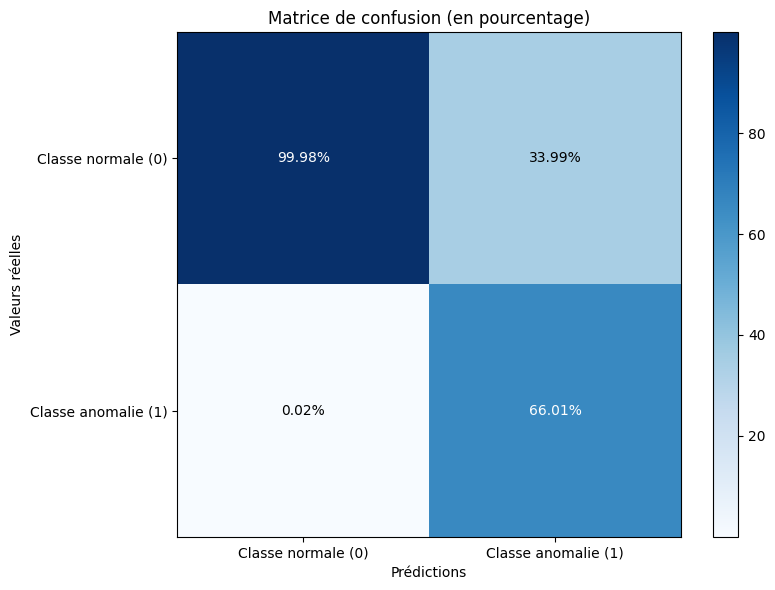

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Chargement des données
data = pd.read_csv('data/data_clusters_anomaly.csv')

# Filtrer pour le cluster 0 uniquement
data_cluster_0 = data[data['cluster'] == 0]
print(f"Nombre de lignes pour le cluster 0 : {len(data_cluster_0)}")

# Nettoyer la colonne 'anomalie' (convertir en entier)
data_cluster_0['anomalie'] = data_cluster_0['anomalie'].astype(int)

# Créer les fenêtres glissantes
def create_sliding_windows(data, window_size, step_size):
    """
    Génère des fenêtres glissantes à partir des données avec chevauchement.
    """
    X, y = [], []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window = data.iloc[start:end]
        # Les caractéristiques sont la consommation
        X.append(window['Consommation'].values)
        # L'étiquette est 1 si une anomalie est présente dans la fenêtre
        y.append(window['anomalie'].max())
    return np.array(X), np.array(y)

# Paramètres des fenêtres glissantes
window_size = 2  # Taille de la fenêtre (nombre de lignes par fenêtre)
step_size = window_size // 2  # Pas (chevauchement de 50 %)

# Générer les données pour le modèle
X, y = create_sliding_windows(data_cluster_0, window_size, step_size)
print(f"Nombre d'échantillons générés : {len(X)}")

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner le modèle Random Forest
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)  # Ajustez les paramètres si nécessaire
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred))
print(f"Exactitude : {accuracy_score(y_test, y_pred)}")

# Précision pour la classe 1 (anomalie)
precision_class_1 = (y_pred == 1) & (y_test == 1)
print(f"Précision pour la classe '1' (anomalie) : {precision_class_1.sum() / (y_pred == 1).sum() if (y_pred == 1).sum() > 0 else 0}")

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Normaliser la matrice pour obtenir des pourcentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percentage = cm_percentage.T  # Si nécessaire

# Afficher la matrice avec matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues')

# Ajouter une barre de couleur
cbar = ax.figure.colorbar(im, ax=ax)

# Ajouter les labels
classes = ['Classe normale (0)', 'Classe anomalie (1)']  # Étiquettes des classes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       ylabel='Valeurs réelles',
       xlabel='Prédictions')

# Ajouter les pourcentages dans les cases
fmt = '.2f'  # Format des nombres
thresh = cm_percentage.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_percentage[i, j], fmt) + '%',
                ha="center", va="center",
                color="white" if cm_percentage[i, j] > thresh else "black")

plt.title("Matrice de confusion (en pourcentage)")
plt.tight_layout()
plt.show()
